1. backward函数没看懂……需要对应公式进行推导  https://willwolf.io/2016/10/18/recurrent-neural-network-gradients-and-lessons-learned-therein/
2. 要注意rnn中的求导，具体情况可以看上述文章




\begin{align*}
z_t &= \mathbf{W}^{x} \mathbf{x} + \mathbf{W}^{h} \mathbf{h}_{t-1} \\
h_t &= \tanh(z_t) \\
y_t &= \mathbf{W}^{y} h_t \\
p_t &= \text{softmax}(y_t) \\
J_t &= \text{crossentropy}(p_t, \text{labels}_t)
\end{align*}

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List

In [5]:
def generate_dataset(size=200, timesteps=25):
    x, y = [], []
    sin_wave = np.sin(np.arange(size))
    for step in range(sin_wave.shape[0] - timesteps):
        x.append(sin_wave[step: step + timesteps])
        y.append(sin_wave[step + timesteps])
    return np.array(x).reshape(len(y), timesteps, 1), np.array(y).reshape(len(y), 1)

In [12]:
x, y = generate_dataset()
print(x.shape, y.shape)

(175, 25, 1) (175, 1)


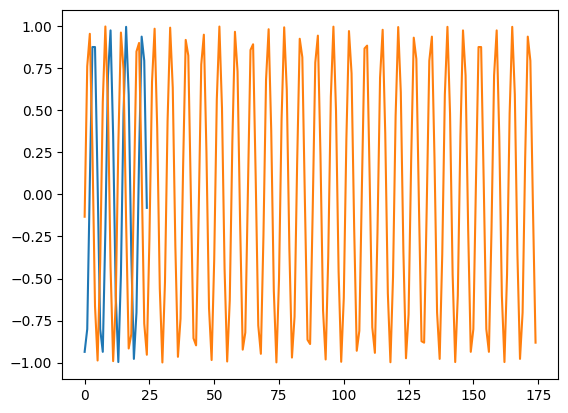

In [16]:
plt.plot(x[-1])
plt.plot(y)

In [ ]:
# Generate dataset
x, y = generate_dataset()
x_test, y_test = generate_dataset(300)
x_test = x_test[250:]  # 取出后25个做测试
y_test = y_test[250:]  # 取出后25个做测试

plt.plot(x_test[-1])
plt.plot(y_test)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:07<00:00,  3.47it/s]


<Figure size 640x480 with 0 Axes>

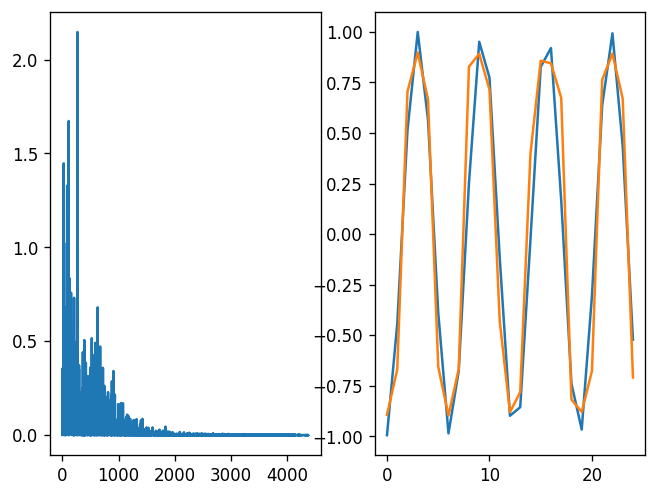

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List

def generate_dataset(size=200, timesteps=25):
    x, y = [], []
    sin_wave = np.sin(np.arange(size))
    for step in range(sin_wave.shape[0] - timesteps):
        x.append(sin_wave[step: step + timesteps])
        y.append(sin_wave[step + timesteps])
    return np.array(x).reshape(len(y), timesteps, 1), np.array(y).reshape(len(y), 1)

# Generate dataset
x, y = generate_dataset()
x_test, y_test = generate_dataset(300)
x_test = x_test[250:]  # 取出后25个做测试
y_test = y_test[250:]  # 取出后25个做测试

class SimpleRNN:
    def __init__(self, x, y, hidden_units:int) -> None:  # hidden_units设置为1 
        self.x = x
        self.y = y
        self.hidden_units = hidden_units
        self.Wx = np.random.randn(self.hidden_units, self.x.shape[2])  # (100, 1)
        self.Wh = np.random.randn(self.hidden_units, self.hidden_units)  # (100, 100)
        self.Wy = np.random.randn(self.y.shape[1], self.hidden_units)  # (1, 100)
    
    def cell(self, xt, ht_1):
        zt = np.dot(self.Wx, xt.reshape(1, 1)) + np.dot(self.Wh, ht_1)  # (100, 1)
        ht = np.tanh(zt)
        yt = np.dot(self.Wy, ht)  # (1, 1)
        return ht, yt
    
    def forward(self, sample:int):
        sample_x, sample_y = self.x[sample], self.y[sample]
        ht = np.zeros((self.hidden_units, 1))
        self.hidden_states = [ht]
        self.inputs = []

        for step in range(len(sample_x)):
            ht, yt = self.cell(sample_x[step], ht)
            self.inputs.append(sample_x[step].reshape(1, 1))
            self.hidden_states.append(ht)
        
        self.error = yt - sample_y
        self.loss = 0.5 * self.error**2
        self.yt = yt

    def backward(self):
        n = len(self.inputs)
        dyt = self.error  # the gradient of the output
        dWy = np.dot(dyt, self.hidden_states[-1].T)  # the gradient of the output weights

        # the gradient of the hidden state
        dht = np.dot(dyt, self.Wy).T
        dWx = np.zeros(self.Wx.shape)
        dWh = np.zeros(self.Wh.shape)
        for step in reversed(range(n)):
            temp = (1 - self.hidden_states[step+1]**2) * dht
            dWx += np.dot(temp, self.inputs[step].T)
            dWh += np.dot(temp, self.hidden_states[step].T)
            dht = np.dot(self.Wh, temp)
        dWy = np.clip(dWy, -1, 1)
        dWx = np.clip(dWx, -1, 1)
        dWh = np.clip(dWh, -1, 1)

        self.Wy -= self.lr * dWy
        self.Wh -= self.lr * dWh
        self.Wx -= self.lr * dWx

    # Training function
    def train(self, epochs, learning_rate):
        self.Ovr_loss = []
        self.lr = learning_rate
        for epoch in tqdm(range(epochs)):
            for sample in range(self.x.shape[0]):
                self.forward(sample)
                self.backward()
                self.Ovr_loss.append(np.squeeze(self.loss / self.x.shape[0]))
                self.loss = 0

    # Testing function
    def test(self, x, y):
        self.x = x
        self.y = y
        self.outputs = []
        for sample in range(len(x)):
            self.forward(sample)
            self.outputs.append(self.yt)

# Create SimpleRNN instance and train
rnn = SimpleRNN(x, y, 100)
rnn.train(25, 1e-2)

# Test the trained SimpleRNN
rnn.test(x_test, y_test)

# Plot the results
plt.tight_layout()
plt.figure(dpi=120)
plt.subplot(121)
plt.plot(rnn.Ovr_loss)
plt.subplot(122)
plt.plot([i for i in range(len(x_test))], y_test, np.array(rnn.outputs).reshape(y_test.shape))
plt.show()